In [16]:
import torch
from torch.autograd import Variable
import pennylane as qml

from pennylane import numpy as np

from random import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot as plt

from tqdm import tqdm
%matplotlib inline

import scipy
from scipy import optimize

import time

In [33]:
class L2L(nn.Module):
    dev = qml.device('default.qubit', wires=2)

    def __init__(self, function):
        super().__init__()
        self.num_feats = 3  # rnn_output, qnn input params
        self.batch_size = 12
        self.rnn_input_size = 1 # qnn output size
        
        self.hid_cell = None
        self.rnn_output = None
        self.qnn_output = None
        
        self.lstm = nn.LSTM(
            input_size=self.rnn_input_size, hidden_size=self.num_feats, num_layers=1, dropout=0
        )
        
        self.function = function
        self.target = None

    def init_hid_cell(self, seq_len=1):
        self.rnn_output = torch.zeros(seq_len, self.batch_size, self.num_feats)
        self.qnn_output = torch.zeros(seq_len, self.batch_size, self.rnn_input_size)

        hidden = torch.zeros(seq_len, self.batch_size, self.num_feats)
        cell = torch.zeros(seq_len, self.batch_size, self.num_feats)
        self.hid_cell = (hidden, cell)

    def init_target(self):
        self.target = (torch.rand(self.batch_size, self.rnn_input_size)-0.5)*2

    def step(self):
        assert self.hid_cell is not None
    
        x = self.qnn_output[[-1], :, :]
        # display(f'RNN input {x.shape}')
        
        rnn_output, self.hid_cell = self.lstm(x, self.hid_cell)
        self.rnn_output = torch.cat((self.rnn_output, rnn_output), dim=0) #(seq_dim, batch_size, feature_size)
        # display(f'RNN output: {rnn_output.shape} RNN hist {self.rnn_output.shape}')
        
        assert rnn_output.shape[0] == 1
        qnn_output = torch.zeros_like(x)
        # this is gonna turn into proper batch handling
        for i in range(rnn_output.shape[1]):
            qnn_input_batch_element = rnn_output[0, i, :]
            qnn_output_batch_element = self.function(qnn_input_batch_element)
            qnn_output[0, i, :] = qnn_output_batch_element # .view(1, 1, -1)
        qnn_output[0,:,:] = torch.abs(qnn_output[0,:,:] - self.target)
        # display(f'circuit output: {qnn_output.shape}')
        self.qnn_output = torch.cat((self.qnn_output, qnn_output), dim=0)

        return self.qnn_output

    def loss(self):
        # display(f'true: {true.shape}, pred: {self.qnn_output.shape}')
        best_up_to = torch.zeros_like(self.qnn_output)
        # according to the paper, we do min{f_t - min{f_j}, 0} where j < t *not j <= t*
        # so for the very first qnn output, there is no history
        best_up_to[1, :, :] = self.qnn_output[1, :, :]
        # go along the sequence axis which is dim=0
        assert self.qnn_output.shape[0] > 2 # otherwise we need to skip the for loop!
        for i in range(2, self.qnn_output.shape[0]):
            # array/tensor slicing is inclusive on the left and exclusive on the right
            best_up_to[i, :, :], _ = self.qnn_output[1:i, :, :].min(dim=0)
        clipped_err = self.qnn_output[1:] - best_up_to[1:] #torch.min(self.qnn_output[1:] - best_up_to[1:], 0)

        return clipped_err.mean()

    def numpy_output(self):
        return self.qnn_output.detach().numpy().squeeze()

dev = qml.device('default.qubit', wires=2)
@qml.qnode(dev, interface='torch')
def circuit(parameters):
    phi = 2*np.pi*parameters[:2]
    theta = 2*np.pi*parameters[-1]
    qml.RX(phi[0], wires=0)
    qml.RZ(phi[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RX(theta, wires=0)
    return qml.expval(qml.PauliZ(0))

100%|██████████| 100/100 [02:07<00:00,  1.32s/it]

CPU times: user 2min 45s, sys: 1min 29s, total: 4min 15s
Wall time: 2min 7s


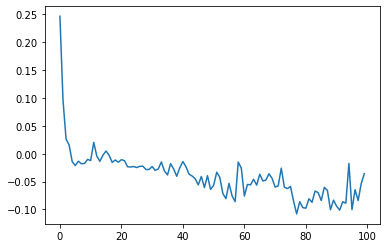

In [37]:
%%time 
l2l = L2L(circuit)
optimizer = optim.Adam(l2l.parameters(), lr=0.1)
num_epoch = 100
num_steps = 10
all_loss = []
for epoch_ind in tqdm(range(num_epoch)):
    l2l.zero_grad()
    l2l.init_hid_cell()
    l2l.init_target()
    for i in range(num_steps):
        l2l.step()
#         print(l2l.qnn_output[])
    loss = l2l.loss()
    loss.backward()
    optimizer.step()
    all_loss.append(loss.item())
plt.plot(all_loss)

In [35]:
target = 0.33
num_steps = 25

# neural optimizer
def neural_optimizer(target):
    l2l.batch_size = 1

    l2l.init_hid_cell()
    l2l.target = torch.tensor([[target]])

    for i in range(num_steps):
        l2l.step()

    return l2l.qnn_output[1:].view(-1).detach().numpy()

# gradient descent
def gradient_descent(target, dev):
    @qml.qnode(dev, interface='torch')
    def circuit(phi, theta):
        qml.RX(phi[0], wires=0)
        qml.RZ(phi[1], wires=1)
        qml.CNOT(wires=[0, 1])
        qml.RX(theta[0], wires=0)
        return qml.expval(qml.PauliZ(0))

    def cost(phi, theta):
        result = circuit(phi, theta)
        return torch.abs(result - target)**2, result

    phi = Variable(2*np.pi*torch.rand(2), requires_grad=True)
    theta = Variable(2*np.pi*torch.rand(1), requires_grad=True)

    opt = torch.optim.Adam([phi, theta], lr = 0.1)

    def closure():
        opt.zero_grad()
        loss, result = cost(phi, theta)
        loss.backward()
        return loss, result

    GD_output = []

    for i in range(num_steps):
        loss, result = opt.step(closure)
#         phi_final, theta_final = opt.param_groups[0]['params']
#         GD_output.append(circuit(phi_final, theta_final)-target)
        GD_output.append(result-target)

    return GD_output

#
def neldermead(target, dev):

    @qml.qnode(dev, interface='torch')
    def circuit(parameters):
        qml.RX(parameters[0], wires=0)
        qml.RZ(parameters[1], wires=1)
        qml.CNOT(wires=[0, 1])
        qml.RX(parameters[2], wires=0)
        return qml.expval(qml.PauliZ(0))
    
    def cost(parameters):
        result = circuit(parameters)
        return torch.abs(result - target)**2
    
    history = []
    def callback(x):
        fobj = circuit(x)
        history.append(fobj)
    
    initial_par = 2*np.pi*np.random.rand(3)
    opt_parameters = scipy.optimize.minimize(cost, initial_par, method='Nelder-Mead', callback=callback,
                                             options={'maxfev': num_steps, 'return_all': False})
    
    return opt_parameters, history

start 1
0.025946855545043945
start 2
0.11304759979248047
start 3
0.029002666473388672


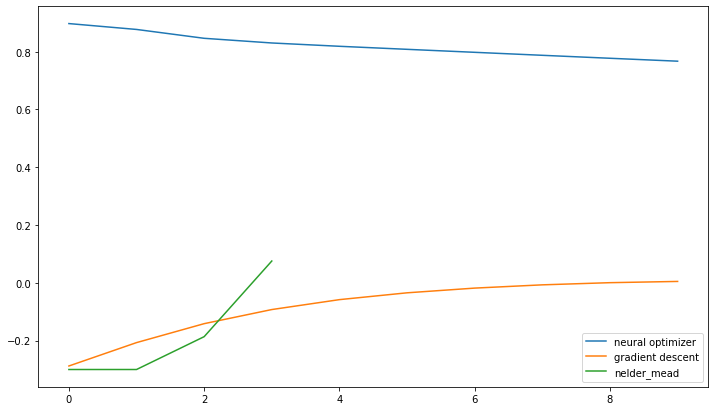

In [42]:
target = 0.1

fig, ax = plt.subplots(figsize = (12,7))

dev = qml.device('default.qubit', wires=2)
# dev = qml.device('forest.qvm', device='Aspen-4-2Q-A', shots=shots)

@qml.qnode(dev, interface='torch')
def circuit(parameters):
    phi = 2*np.pi*parameters[:2]
    theta = 2*np.pi*parameters[-1]
    qml.RX(phi[0], wires=0)
    qml.RZ(phi[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RX(theta, wires=0)
    return qml.expval(qml.PauliZ(0))

l2l.function = circuit

start = time.time()

print('start 1')
ax.plot(neural_optimizer(target))
stop = time.time()
print(stop-start)
print('start 2')
ax.plot(gradient_descent(target, dev))
print(time.time()-stop)
stop = time.time()
print('start 3')
opt_par, nelder_mead = neldermead(target, dev)
ax.plot(np.array(nelder_mead)[:10]-target)
print(time.time()-stop)
ax.legend(['neural optimizer', 'gradient descent', 'nelder_mead'])

NameError: name 'shots' is not defined

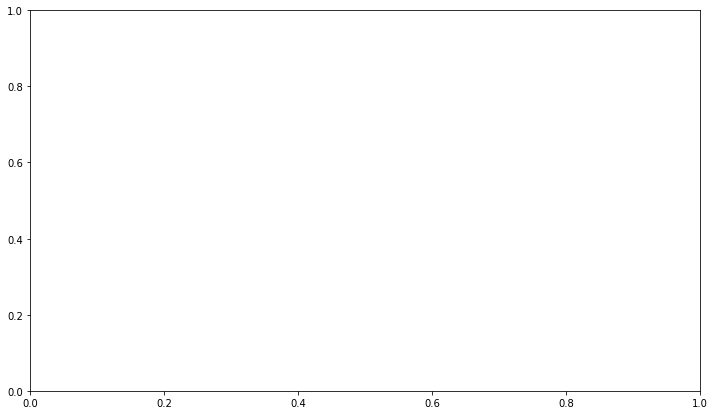

In [26]:
target = 0.9

fig, ax = plt.subplots(figsize = (12,7))

# dev = qml.device('default.qubit', wires=2)
dev = qml.device('forest.qvm', device='Aspen-4-2Q-A', shots=shots)

@qml.qnode(dev, interface='torch')
def circuit(parameters):
    phi = 2*np.pi*parameters[:2]
    theta = 2*np.pi*parameters[-1]
    qml.RX(phi[0], wires=0)
    qml.RZ(phi[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RX(theta, wires=0)
    return qml.expval(qml.PauliZ(0))

l2l.function = circuit

start = time.time()

print('start 1')
ax.plot(neural_optimizer(target))
stop = time.time()
print(stop-start)
print('start 2')
ax.plot(gradient_descent(target, dev))
print(time.time()-stop)
stop = time.time()
print('start 3')
opt_par, nelder_mead = neldermead(target, dev)
ax.plot(np.array(nelder_mead)[:10]-target)
print(time.time()-stop)
ax.legend(['neural optimizer', 'gradient descent', 'nelder_mead'])

In [59]:
opt_par

 final_simplex: (array([[4.64146552, 0.75340017, 4.88201645],
       [4.71977246, 0.82535412, 4.54091486],
       [4.70662243, 0.74963787, 4.74936583],
       [4.66222872, 0.76468706, 4.70435937]]), array([0.47339502, 0.48823777, 0.48970159, 0.49056379]))
           fun: 0.4733950222647086
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 25
           nit: 12
        status: 1
       success: False
             x: array([4.64146552, 0.75340017, 4.88201645])